# Estimativa de Fase

In [8]:
# === NumPy, SciPy e otimização ===
import numpy as np
from scipy.optimize import minimize

# === Visualização ===
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
from rustworkx.visualization import mpl_draw as draw_graph
import time

# === Estruturas de grafos ===
import networkx as nx
import rustworkx as rx
from qiskit_algorithms.optimizers import SPSA

# === Qiskit: circuitos, operadores e transpiler ===
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.circuit.library import QAOAAnsatz, PauliEvolutionGate
from qiskit.synthesis.evolution import LieTrotter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# === Qiskit Aer (simulação local) ===
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler as AerSampler

# === Qiskit Runtime (execução em hardware IBM) ===
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2, SamplerV2

# === Qiskit Primitives ===
# from qiskit.primitives import Sampler, BaseSamplerV2
from qiskit.circuit.library import QFTGate, QFT
from qiskit.synthesis.qft import synth_qft_full
from qiskit.circuit import Parameter, QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Pauli, SparsePauliOp
# === Qiskit Optimization ===
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.minimum_eigensolvers import QAOA
from qiskit_optimization.optimizers import COBYLA, NELDER_MEAD

# ---- Importações necessárias (atualizadas para Qiskit 2.x) ----
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorEstimator as Estimator  # Correção: Use StatevectorEstimator
from qiskit.primitives import StatevectorSampler as Sampler  # Correção: Use StatevectorSampler
from qiskit.circuit.library import QAOAAnsatz  # Novo: QAOAAnsatz em vez de QAOA
from qiskit.quantum_info import SparsePauliOp  # Para operadores
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager  # transpiler para versões antigas/compatíveis
from qiskit import transpile
import numpy as np
from scipy.optimize import minimize  # Otimizador clássico externo
from qiskit_optimization.optimizers import SPSA



from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

/tmp/ipykernel_6484/1797273781.py:23: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(4, inverse = True), qr_aux)


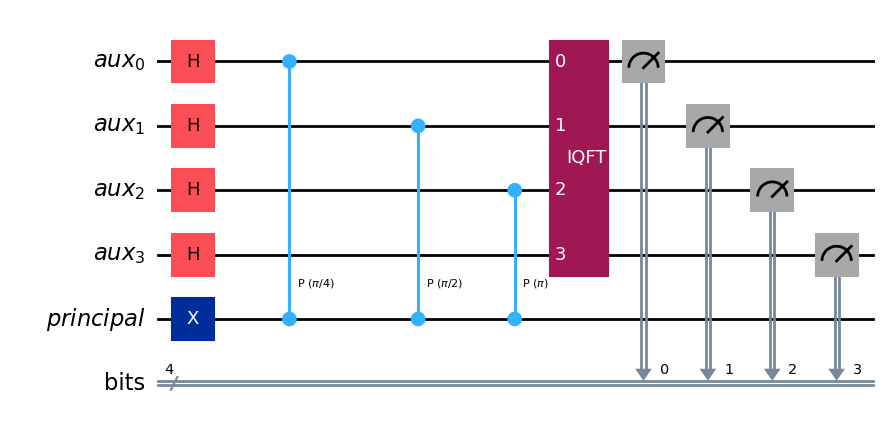

In [38]:
qr_aux = QuantumRegister(4, name = 'aux')
qr_principal = QuantumRegister(1, name = 'principal')
cr_aux = ClassicalRegister(4, name = 'bits') 

qc = QuantumCircuit(qr_aux,qr_principal, cr_aux)


for i in range(4):
    qc.h(qr_aux[i])


qc.x(qr_principal[0])

t1 = np.pi/4
qc.cp(t1, qr_aux[0], qr_principal) 

t2 = np.pi/2
qc.cp(t2, qr_aux[1], qr_principal)

t3 = np.pi
qc.cp(t3, qr_aux[2], qr_principal)

qc.append(QFT(4, inverse = True), qr_aux)

qc.measure(qr_aux, cr_aux)

qc.draw('mpl')


Resultados da medição:
{'0010': 1024}


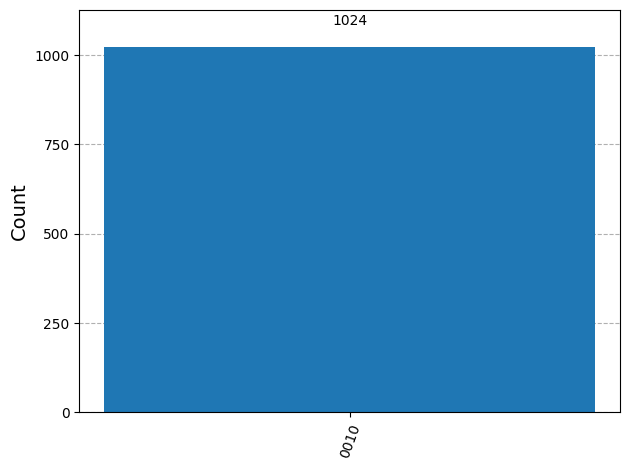

In [42]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts(qc)

print("\nResultados da medição:")
print(counts)

# Plotar histograma
plot_histogram(counts)

8


/tmp/ipykernel_6484/2696065884.py:34: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse = True), qr_aux)


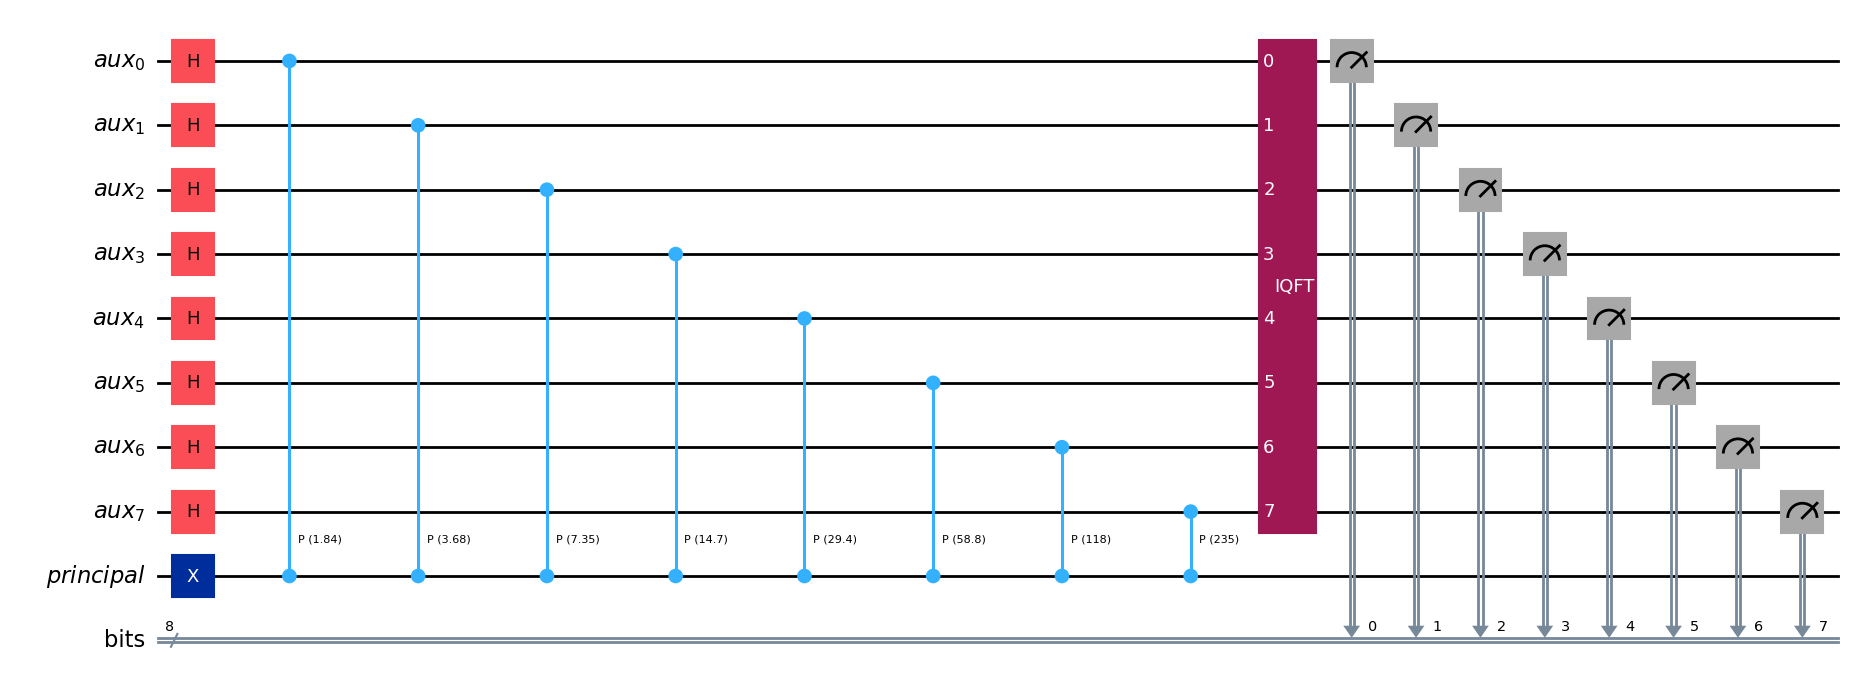

In [76]:
import random

phi = random.uniform(0, 1)


R = np.array([[1, 0],
              [0, np.exp(2j*np.pi*phi)]]) 

R_autovalores = np.linalg.eig(R)


n = 5
erro = 0.1
t_aux = 5 + np.log2(2 + 1/(2*erro)) 
t = np.ceil(np.round(t_aux).astype(int))
print(t)

qr_aux = QuantumRegister(t, name = 'aux')
qr_principal = QuantumRegister(1, name = 'principal')
cr_aux = ClassicalRegister(t, name = 'bits') 

qc = QuantumCircuit(qr_aux,qr_principal, cr_aux)

for i in range(t):
    qc.h(i) 

qc.x(qr_principal[0])

for j in range(t):
    angulo = 2 * np.pi * phi * (2**j)
    qc.cp(angulo, qr_aux[j], qr_principal[0]) 


qc.append(QFT(t, inverse = True), qr_aux)

qc.measure(qr_aux, cr_aux)

# qc.draw('mpl')
display(qc.draw('mpl', fold=-1))




Resultados da medição:
{'01000100': 1, '01001011': 991, '01001001': 4, '00111100': 1, '01001101': 1, '01001100': 6, '01000101': 1, '01000110': 1, '01001110': 4, '01001010': 10, '01001111': 1, '01010001': 1, '00111011': 1, '01001000': 1}


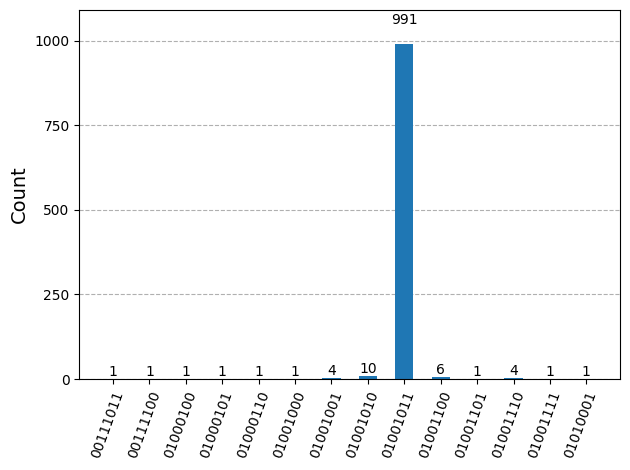

In [77]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts(qc)

print("\nResultados da medição:")
print(counts)

# Plotar histograma
plot_histogram(counts)

# PROBLEMA: Sistema de Diagnóstico Médico Quântico
### Cenário:
### Você trabalha em um hospital e recebeu um novo dispositivo quântico de diagnóstico. Ele tem uma porta U que evolui estados de sintomas para diagnósticos.

[ 1.        +0.j          0.30901699+0.95105652j -0.80901699+0.58778525j
 -0.30901699-0.95105652j]

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

10


/tmp/ipykernel_21013/1355314852.py:38: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse = True), qr_aux)


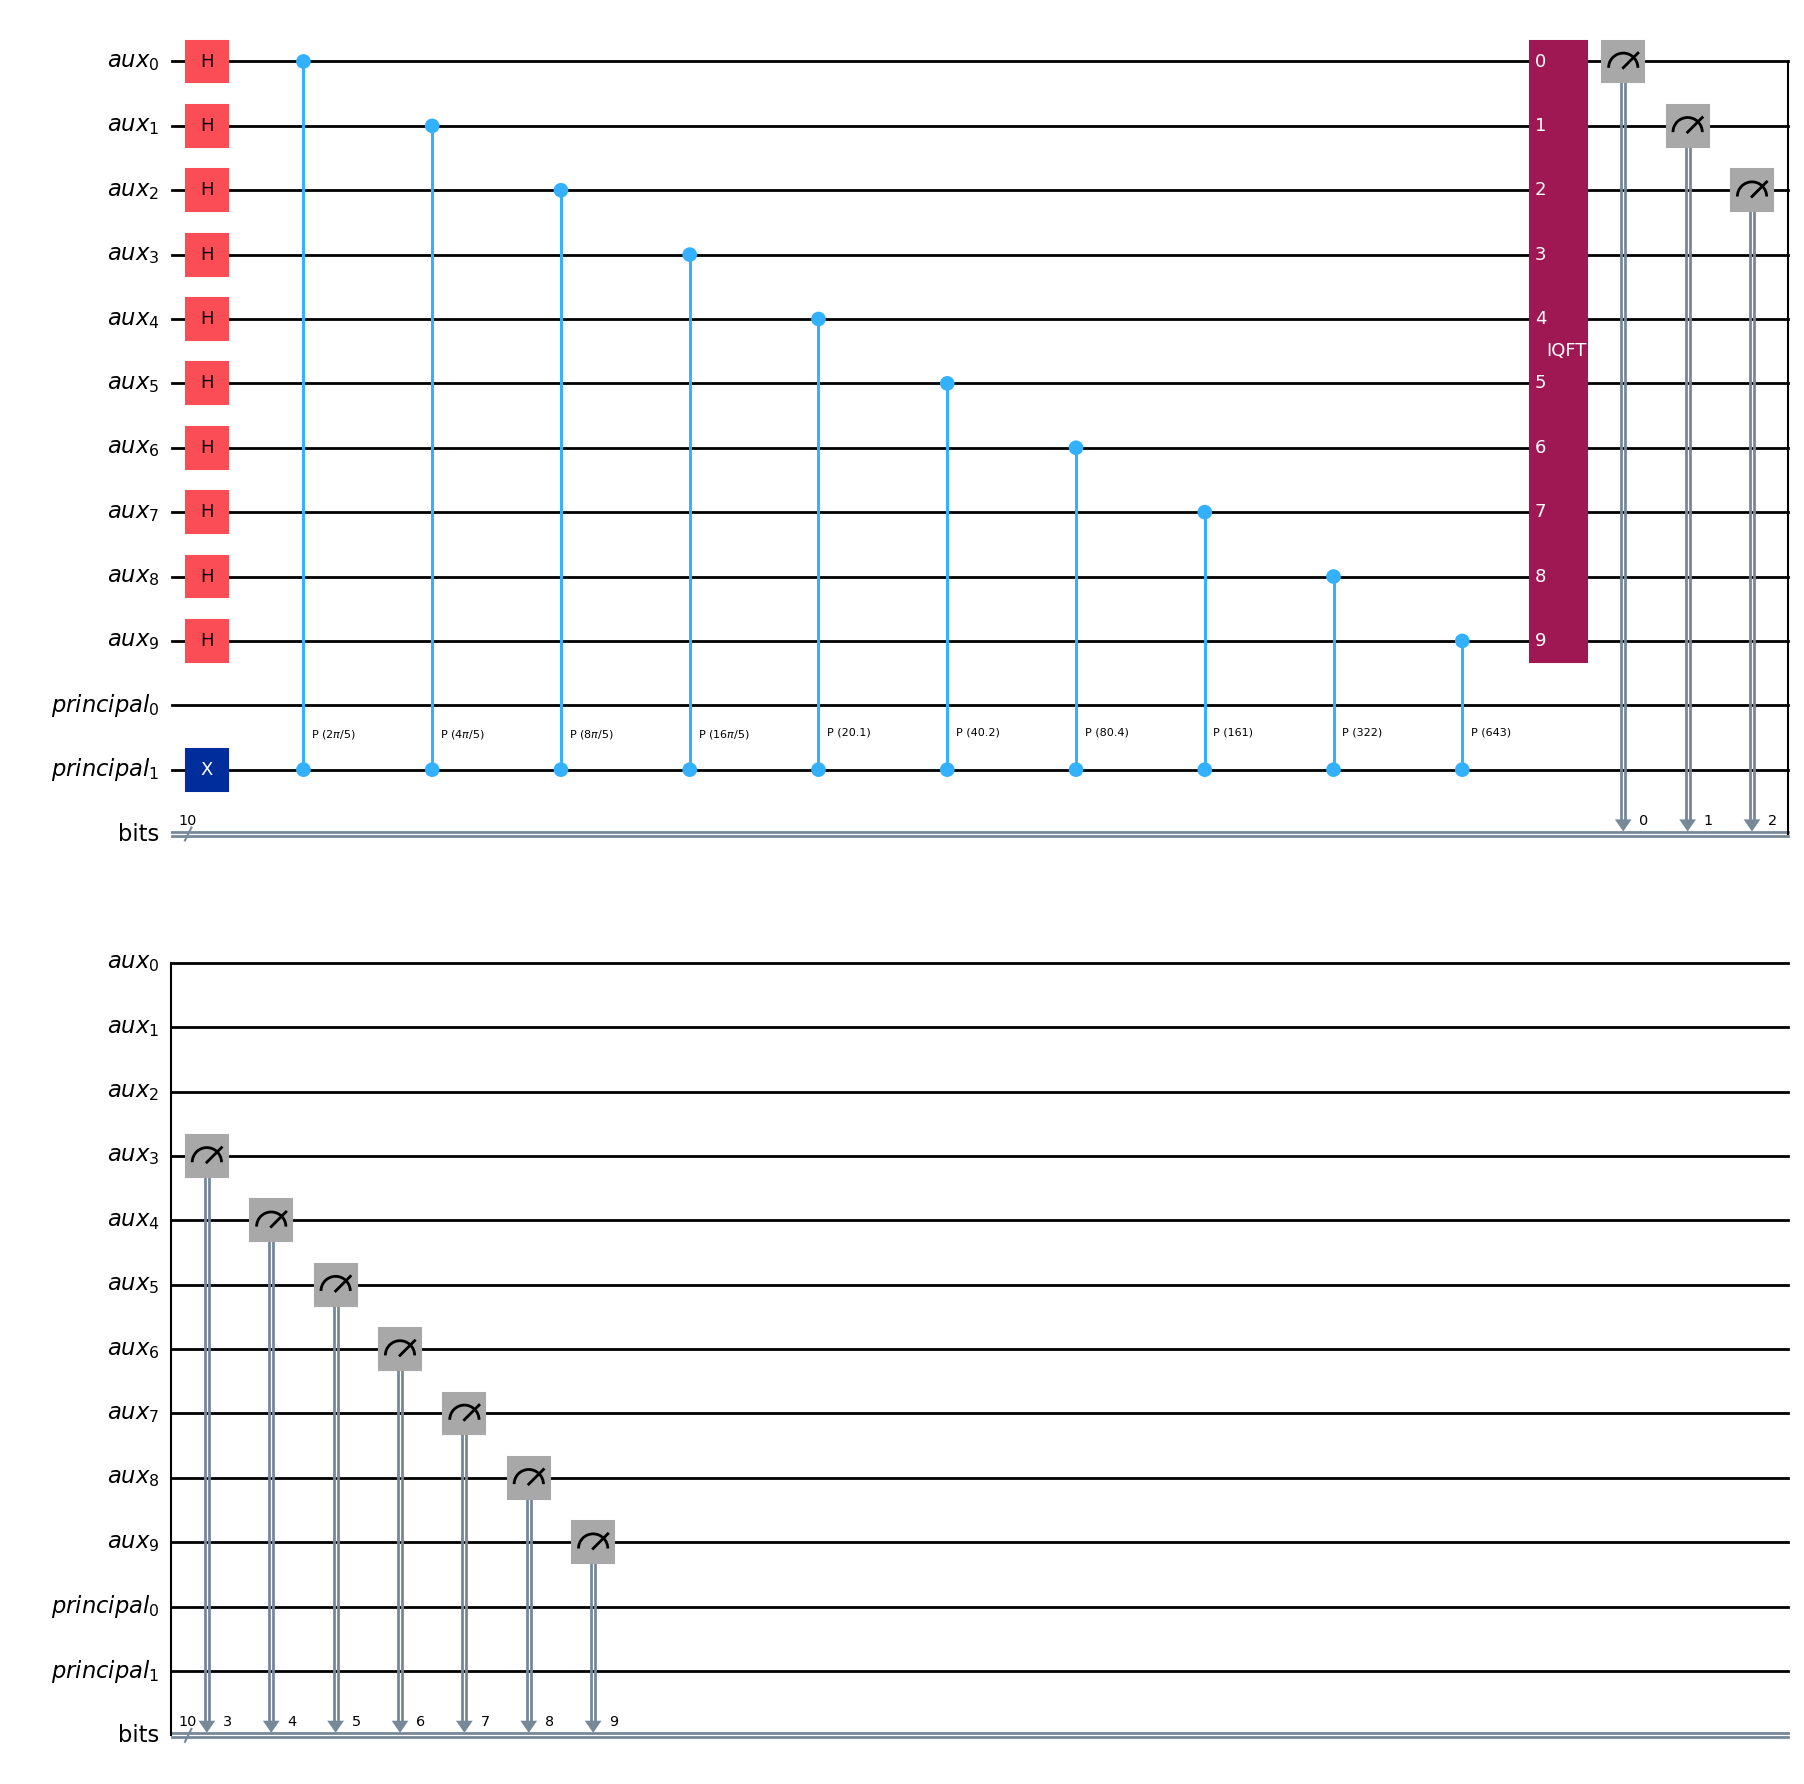

In [5]:
U = np.array([
        [1, 0, 0, 0],
        [0, np.exp(2j*np.pi*0.2), 0, 0],
        [0, 0, np.exp(2j*np.pi*0.4), 0],
        [0, 0, 0, np.exp(2j*np.pi*0.7)]
    ]) 

auto_vetor , auto_valor = np.linalg.eig(U) 

print(f"{auto_vetor}\n")
print(f"{auto_valor}\n")


n = 5
erro = 0.1
t_aux = 5 + np.log2(2 + 1/(2*erro)) 
t = (np.ceil(np.round(t_aux).astype(int))) + 2
print(t)
qr_aux = QuantumRegister(t, name = 'aux')
qr_principal = QuantumRegister(2, name = 'principal')
cr_aux = ClassicalRegister(t, name = 'bits') 

qc = QuantumCircuit(qr_aux,qr_principal, cr_aux)

phi = 0.2

for i in range(t):
    qc.h(i)

qc.x(qr_principal[1])

 

for j in range(t):
    angulo = 2 * np.pi * phi * (2**j)
    qc.cp(angulo, qr_aux[j], qr_principal[1])

qc.append(QFT(t, inverse = True), qr_aux)


qc.measure(qr_aux, cr_aux)

qc.draw('mpl')




Resultados da medição:
{'0011010000': 1, '0011000101': 1, '0011010101': 1, '0011010100': 1, '0011011000': 1, '0010110000': 1, '0011011011': 1, '0011010011': 1, '0011001000': 3, '0011000100': 1, '0011001100': 51, '0011010010': 1, '0011001111': 7, '0011000111': 1, '0011001010': 7, '0011001011': 11, '0011001110': 27, '0101000000': 1, '0011000001': 1, '0011001001': 2, '0010111010': 1, '0011010001': 1, '0011001101': 900, '0010111101': 1}


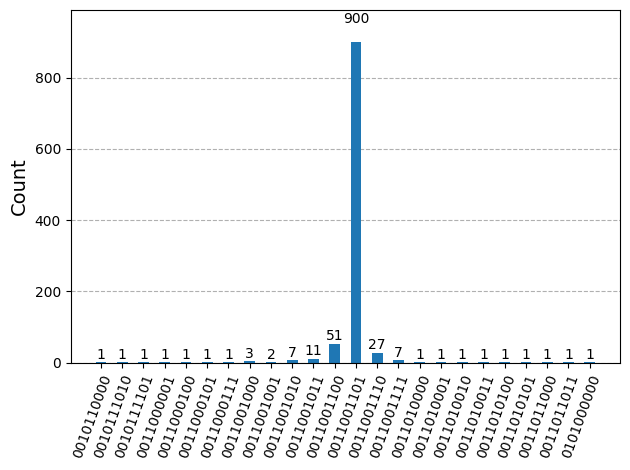

In [6]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()


counts = result.get_counts(qc)

print("\nResultados da medição:")
print(counts)

# Plotar histograma
plot_histogram(counts)

1.5707963267948966
3.141592653589793
6.283185307179586


/tmp/ipykernel_21013/3356885746.py:21: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True), qr_aux)


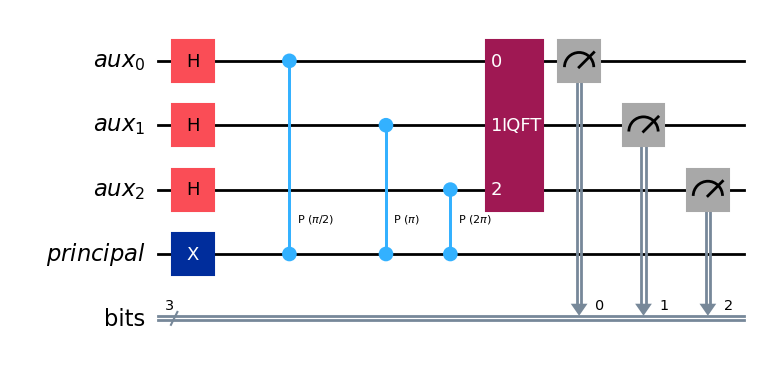

In [31]:
t = 3
phi = 0.25 

qr_aux = QuantumRegister(t, 'aux')
cr_aux = ClassicalRegister(t, 'bits')
qr_principal = QuantumRegister(1, 'principal') 


qc = QuantumCircuit(qr_aux, qr_principal, cr_aux) 

qc.x(qr_principal[0])

for i in range(t):
    qc.h(qr_aux[i])

for j in range(t):
    angulo = 2 * np.pi * phi * (2**j)  
    qc.cp(angulo, qr_aux[j], qr_principal[0])
    print(angulo)

qc.append(QFT(t, inverse=True), qr_aux)

qc.measure(qr_aux, cr_aux)


qc.draw('mpl')


Resultados da medição:
{'010': 1024}


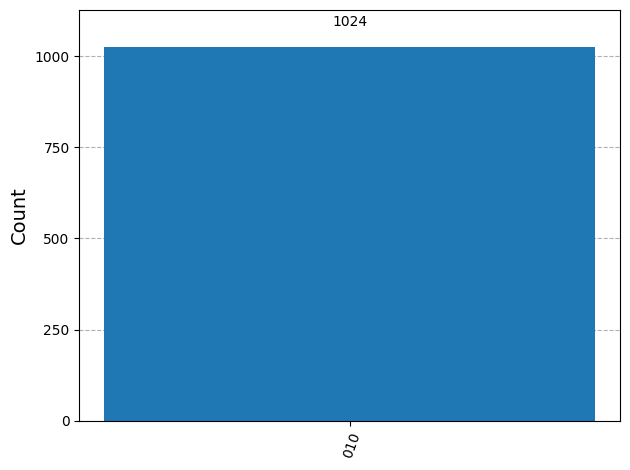

In [32]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()


counts = result.get_counts(qc)

print("\nResultados da medição:")
print(counts)

# Plotar histograma
plot_histogram(counts)

In [ ]:
# Operadores para 3 medicamentos (cada um age em 2 qubits)
U_A = np.diag([np.exp(2j*np.pi*0.05),  # Pouco eficaz
               np.exp(2j*np.pi*0.02),  # Eficaz
               np.exp(2j*np.pi*0.10),  # Pouco eficaz  
               np.exp(2j*np.pi*0.01)]) # Muito eficaz

U_B = np.diag([np.exp(2j*np.pi*0.15),
               np.exp(2j*np.pi*0.08),
               np.exp(2j*np.pi*0.03),
               np.exp(2j*np.pi*0.12)])

U_C = np.diag([np.exp(2j*np.pi*0.01),
               np.exp(2j*np.pi*0.20),
               np.exp(2j*np.pi*0.01),
               np.exp(2j*np.pi*0.05)])



/tmp/ipykernel_21013/943518727.py:21: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True), qr_aux)


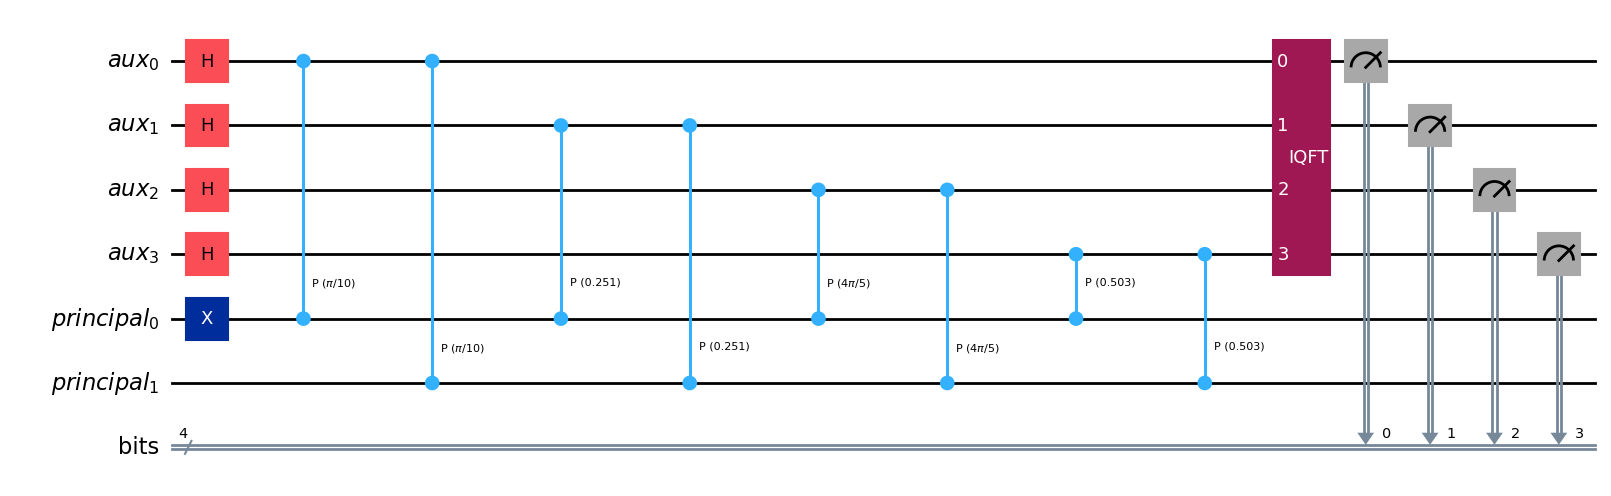

In [40]:
#para U_A 

t = 4
phi = [0.05, 0.02, 0.10, 0.01]

qr_aux = QuantumRegister(t, 'aux') 
cr_aux = ClassicalRegister(t, 'bits')
qr_principal = QuantumRegister(2, 'principal')

qc = QuantumCircuit(qr_aux, qr_principal, cr_aux)

qc.x(qr_principal[0]) 

for i in range(t):
    qc.h(qr_aux[i])

for j in range(t):
    angulo = 2* np.pi * phi[j] * 2**j
    qc.cp(angulo, qr_aux[j], qr_principal) 

qc.append(QFT(t, inverse=True), qr_aux)

qc.measure(qr_aux, cr_aux) 

qc.draw('mpl')



In [45]:


# ========== CONFIGURAÇÃO ==========
t = 4  # qubits auxiliares
phi_fases = [0.05, 0.02, 0.10, 0.01]  # Fases para |00⟩, |01⟩, |10⟩, |11⟩

# ========== CIRCUITO CORRIGIDO ==========
qr_aux = QuantumRegister(t, 'aux') 
cr_aux = ClassicalRegister(t, 'bits')
qr_principal = QuantumRegister(2, 'principal')  # ✅ 2 qubits

qc = QuantumCircuit(qr_aux, qr_principal, cr_aux)

# Vamos testar UMA fase por vez para entender
estado_testar = '01'  # Testar medicamento para tosse
fase_testar = phi_fases[1]  # 0.02 para |01⟩

print(f"Testando fase φ = {fase_testar} para estado |{estado_testar}⟩")

# 1. Preparar estado ESPECÍFICO no principal
if estado_testar[0] == '1':  # bit mais significativo
    qc.x(qr_principal[1])
if estado_testar[1] == '1':  # bit menos significativo  
    qc.x(qr_principal[0])

# 2. Superposição nos auxiliares
for i in range(t):
    qc.h(qr_aux[i])

# 3. Oracle: aplicar fase APENAS quando principal está em |01⟩
# Para |01⟩: q1=0, q0=1 → precisa de anti-controle no q1, controle no q0
for j in range(t):
    angulo = 2 * np.pi * fase_testar * (2**j)  # ✅ Escalonado por 2^j
    
    # Criar gate que só aplica quando: q1=0 AND q0=1
    # Método: converter anti-controle em controle normal
    qc.x(qr_principal[1])  # Transforma |0⟩→|1⟩ no q1
    
    # Agora: controle normal em ambos qubits
    qc.mcp(angulo, [qr_principal[0], qr_principal[1]], qr_aux[j])
    
    # Desfazer transformação
    qc.x(qr_principal[1])

# 4. QFT inversa e medição
qc.append(QFT(t, inverse=True), qr_aux)
qc.measure(qr_aux, cr_aux)

qc.draw('mpl')

# ========== SIMULAÇÃO ==========
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()

print(f"\nResultados para φ = {fase_testar}:")
for estado_bin, contagem in sorted(counts.items()):
    valor = int(estado_bin, 2)
    fase_estimada = valor / (2**t)
    print(f"  {estado_bin} (dec {valor:2d}): {contagem:4d} shots → φ ≈ {fase_estimada:.4f}")

Testando fase φ = 0.02 para estado |01⟩


/tmp/ipykernel_21013/3324580551.py:44: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True), qr_aux)



Resultados para φ = 0.02:
  010 (dec  2): 1024 shots → φ ≈ 0.1250


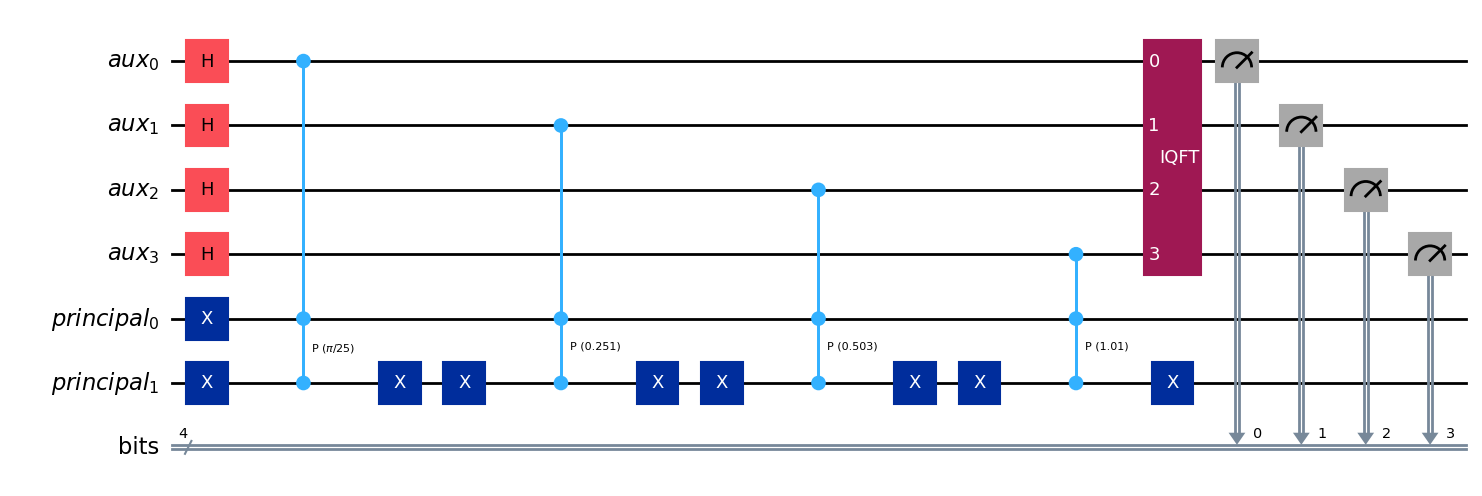

In [46]:
qc.draw('mpl')